In [4]:
import os
import shutil
import sys
import yaml
import numpy as np
import pandas as pd
import random
from datetime import datetime

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_error, root_mean_squared_error


from dataset.dataset_test_recon import MolTestDatasetWrapper

from dataset.get_config import get_config 
import argparse
from torch_geometric.utils import  scatter, softmax

from torch_geometric.data import Data

import torch
from torch import nn
import torch.nn.functional as F

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops
from torch_geometric.nn import global_add_pool, global_mean_pool, global_max_pool

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [5]:
apex_support = False
try:
    sys.path.append('./apex')
    from apex import amp

    apex_support = True
except:
    print("Please install apex for mixed precision training from: https://github.com/NVIDIA/apex")
    apex_support = False


def _save_config_file(model_checkpoints_folder):
    if not os.path.exists(model_checkpoints_folder):
        os.makedirs(model_checkpoints_folder)
        shutil.copy('./config_finetune.yaml', os.path.join(model_checkpoints_folder, 'config_finetune.yaml'))

def get_roc_auc_score(y_true, y_pred, is_valid):
    roc_list = []
    for i in range(y_true.shape[1]):
        #AUC is only defined when there is at least one positive data.
        if np.sum(y_true[:,i] == 1) > 0 and np.sum(y_true[:,i] == -1) > 0:
            is_valid = y_true[:,i]**2 > 0
            roc_list.append(roc_auc_score((y_true[is_valid,i] + 1)/2, y_pred[is_valid,i]))

    if len(roc_list) < y_true.shape[1]:
        print("Some target is missing!")
        print("Missing ratio: %f" %(1 - float(len(roc_list))/y_true.shape[1]))

    return  sum(roc_list)/len(roc_list)




class Normalizer(object):
    """Normalize a Tensor and restore it later. """

    def __init__(self, tensor):
        """tensor is taken as a sample to calculate the mean and std"""
        mean = torch.mean(tensor)
        std = torch.std(tensor)

    def norm(self, tensor):
        return (tensor - mean) / std

    def denorm(self, normed_tensor):
        return normed_tensor * std + mean

    def state_dict():
        return {'mean': mean,
                'std': std}

    def load_state_dict(self, state_dict):
        mean = state_dict['mean']
        std = state_dict['std']


Please install apex for mixed precision training from: https://github.com/NVIDIA/apex


In [6]:
class Args:
    batch_size = 32
    epochs = 200
    init_lr = 0.0005
    init_base_lr = 0.0001
    weight_decay = 1e-6
    
    gpu = 'cuda:0'
    model_type = 'gin'
    num_layer = 5
    emb_dim = 300
    feat_dim = 300
    dropout = 0.3
    pool = 'mean'
    seed = '781'

    task_name = 'lipo'
    splitting = 'scaffold'
    random_masking = 1
    mask_rate = 0.9
    mask_edge = 1 
    alpha = 0.1
    reduceTrain = 1

args = Args()

In [7]:
config = yaml.load(open("config_finetune.yaml", "r"), Loader=yaml.FullLoader)

In [8]:
seed = args.seed

In [9]:
config['batch_size'] = args.batch_size
config['epochs'] = args.epochs
config['init_lr'] = args.init_lr
config['init_base_lr'] = args.init_base_lr
# config['weight_decay'] = args.weight_decay
config['gpu'] = args.gpu   
config['model']['num_layer'] = args.num_layer
config['model']['emb_dim'] = args.emb_dim
config['model']['feat_dim'] = args.feat_dim
config['model']['drop_ratio'] = args.dropout
config['model']['pool'] = args.pool

config['task_name'] = args.task_name
config['dataset']['seed'] = seed

config['dataset']['splitting'] = args.splitting

In [10]:
seed =  int(args.seed)

In [11]:
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

config['task_name'] = config['task_name'].lower()
# config['model']['mask_rate'] = args.mask_rate

In [12]:
# del config['model']['mask_rate']

In [13]:
config = get_config(config)

### main으로 넘어옴

In [14]:
dataset = MolTestDatasetWrapper(config['batch_size'],
                                **config['dataset'],
                                random_masking=args.random_masking,
                                mask_rate=args.mask_rate,
                                mask_edge=args.mask_edge)

## step 과 test 옮기기

In [15]:
    def _get_device():
        if torch.cuda.is_available() and config['gpu'] != 'cpu':
            device = config['gpu']
            torch.cuda.set_device(device)
            args.deviceName = "cuda" + str(device[-1])

        else:
            
            device = 'cpu'
            args.deviceName = 'cpu'

        print("Running on:", device)

        return device

In [16]:
device = _get_device()

Running on: cuda:0


In [17]:
savefilename = f"finetunerandom_edgePred_{args.task_name}"

In [18]:
savefilename

'finetunerandom_edgePred_lipo'

In [19]:
layout = {
    "recon": {
        "loss_end": ["Multiline", ["loss_end/train", "loss_end/validation"]],
        "loss_recon_node" : ["Multiline", ["loss_recon_node/train"]],
        "loss_recon_edge" : ["Multiline", ["loss_recon_edge/train"]],
        "loss_total" : ["Multiline", ["loss_total/train", "loss_total/validation"]],
        "accuracy": ["Multiline", [ "accuracy/validation"]],
    },
}

In [20]:
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
dir_name =  savefilename + config['task_name'] + '_' + str(args.num_layer) + '_' \
+ str(args.emb_dim) + '_' + str(args.feat_dim)  + '_' + str(args.dropout) + '_' \
+ str(args.splitting) + '_' + str(args.deviceName) + '_' + str(args.seed) + '_' + str(current_time)

log_dir = os.path.join('finetune', dir_name)
writer = SummaryWriter(log_dir=log_dir)
writer.add_custom_scalars(layout)

dataset = dataset
if config['dataset']['task'] == 'classification':
    criterion =  nn.BCEWithLogitsLoss(reduction = "none")
elif config['dataset']['task'] == 'regression':
    if config["task_name"] in ['qm7', 'qm8', 'qm9']:
        criterion = nn.L1Loss()
    else:
        criterion = nn.MSELoss()
criterion_recon = nn.CrossEntropyLoss()

In [21]:
train_loader, valid_loader, test_loader = dataset.get_data_loaders()

4199
About to generate scaffolds
Generating scaffold 0/4199
Generating scaffold 1000/4199
Generating scaffold 2000/4199
Generating scaffold 3000/4199
Generating scaffold 4000/4199
About to sort in scaffold sets


## train_loader 저장 후 불러오기

In [35]:
file_base = f"./data_save/{config['task_name']}/{config['task_name']}_{args.splitting}_{args.seed}.pkl"
file_base

'./data_save/bbbp/bbbp_scaffold_42.pkl'

In [36]:
dir_name = f"./data_save/{config['task_name']}"

In [37]:
dir_name

'./data_save/bbbp'

In [38]:
file_name_train = dir_name + f"/{config['task_name']}_{args.splitting}_{args.seed}_train.pkl" 
file_name_valid = dir_name + f"/{config['task_name']}_{args.splitting}_{args.seed}_valid.pkl" 
file_name_test = dir_name + f"/{config['task_name']}_{args.splitting}_{args.seed}_test.pkl"

In [39]:
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

In [40]:
import pickle
with open(file_name_train, 'wb') as f:
    pickle.dump(train_loader.dataset, f)

with open(file_name_valid, 'wb') as f:
    pickle.dump(valid_loader.dataset, f)
    
with open(file_name_test, 'wb') as f:
    pickle.dump(test_loader.dataset, f)

In [41]:
import pickle

with open(file_name_train, 'rb') as f:
    train_dataset = pickle.load(f)

with open(file_name_valid, 'rb') as f:
    valid_dataset = pickle.load(f)

with open(file_name_test, 'rb') as f:
    test_dataset = pickle.load(f)

In [42]:
from torch_geometric.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers = config['dataset']['num_workers'])
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers = config['dataset']['num_workers'])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers = config['dataset']['num_workers'])

## 저장 끝

In [22]:
selected_datasets = ['FreeSolv',
                        'ESOL',
                         'qm7',
                        'Lipo',
                        'BACE',
                        'BBBP',
                        'ClinTox'
                        'sider',
                        'tox21']

In [23]:
selected_datasets_lower = [x.lower() for x in selected_datasets]

In [24]:
class Normalizer(object):
    """Normalize a Tensor and restore it later. """

    def __init__(self, tensor):
        """tensor is taken as a sample to calculate the mean and std"""
        self.mean = torch.mean(tensor)
        self.std = torch.std(tensor)

    def norm(self, tensor):
        return (tensor - self.mean) / self.std

    def denorm(self, normed_tensor):
        return normed_tensor * self.std + self.mean

    def state_dict(self):
        return {'mean': self.mean,
                'std': self.std}

    def load_state_dict(self, state_dict):
        self.mean = state_dict['mean']
        self.std = state_dict['std']

In [25]:
normalizer = None
if config["task_name"] in ['qm7', 'qm9']:
    labels = []
    for d  in train_loader:
        labels.append(d.y)
    labels = torch.cat(labels)
    normalizer = Normalizer(labels)
    print(normalizer.mean, normalizer.std, labels.shape)

In [26]:
num_atom_type = 120 # including the extra mask tokens
num_chirality_tag = 3

num_bond_type = 6 # including aromatic and self-loop edge
num_bond_direction = 3 


class GINEConv(MessagePassing):
    def __init__(self, emb_dim, bias = None):
        super(GINEConv, self,  ).__init__()
        self.emb_dim = emb_dim
        if bias is not None:
            self.mlp = nn.Sequential(
                nn.Linear(emb_dim, 2*emb_dim, bias = bias), 
                nn.ReLU(), 
                nn.Linear(2*emb_dim, emb_dim, bias = bias), 
                
            )
        else:
            self.mlp = nn.Sequential(
                nn.Linear(emb_dim, 2*emb_dim), 
                nn.ReLU(), 
                nn.Linear(2*emb_dim, emb_dim)
            )
        self.edge_embedding1 = nn.Embedding(num_bond_type, emb_dim)
        self.edge_embedding2 = nn.Embedding(num_bond_direction, emb_dim)

        nn.init.xavier_uniform_(self.edge_embedding1.weight.data)
        nn.init.xavier_uniform_(self.edge_embedding2.weight.data)

    def forward(self, x, edge_index, edge_attr, mask_edge = None):
        # add self loops in the edge space
        edge_index = add_self_loops(edge_index, num_nodes=x.size(0))[0]

        # add features corresponding to self-loop edges.
        self_loop_attr = torch.zeros(x.size(0), 2)
        self_loop_attr[:,0] = 4 # bond type for self-loop edge
        self_loop_attr = self_loop_attr.to(edge_attr.device).to(edge_attr.dtype)
        edge_attr = torch.cat((edge_attr, self_loop_attr), dim=0)

        if mask_edge is not None:

            edge_embeddings = torch.zeros(edge_attr.size(0), self.emb_dim).to(edge_attr.device)
        
        else: 
            edge_embeddings = self.edge_embedding1(edge_attr[:,0]) + \
            self.edge_embedding2(edge_attr[:,1])

        return self.propagate(edge_index, x=x, edge_attr=edge_embeddings)

    def message(self, x_j, edge_attr):
        return x_j + edge_attr

    def update(self, aggr_out):
        return self.mlp(aggr_out)

class GINetReconEmbedding(nn.Module):
    """
    Args:
        num_layer (int): the number of GNN layers
        emb_dim (int): dimensionality of embeddings
        drop_ratio (float): dropout rate
        gnn_type: gin, gcn, graphsage, gat
    Output:
        node representations
    """
    def __init__(self, 
        task='classification', num_layer=5, emb_dim=300, feat_dim=512, 
        drop_ratio=0, pool='mean', pred_n_layer=2, pred_act='softplus', num_task = 1
    ):
        super(GINetReconEmbedding, self).__init__()
        self.num_layer = num_layer
        self.emb_dim = emb_dim
        self.feat_dim = feat_dim
        self.drop_ratio = drop_ratio
        self.task = task
        self.num_task = num_task

        self.x_embedding1 = nn.Embedding(num_atom_type, emb_dim)
        self.x_embedding2 = nn.Embedding(num_chirality_tag, emb_dim)
        nn.init.xavier_uniform_(self.x_embedding1.weight.data)
        nn.init.xavier_uniform_(self.x_embedding2.weight.data)

        # List of MLPs
        self.gnns = nn.ModuleList()
        for layer in range(num_layer):
            self.gnns.append(GINEConv(emb_dim))

        # List of batchnorms
        self.batch_norms = nn.ModuleList()
        for layer in range(num_layer):
            self.batch_norms.append(nn.BatchNorm1d(emb_dim))

        if pool == 'mean':
            self.pool = global_mean_pool
        elif pool == 'max':
            self.pool = global_max_pool
        elif pool == 'add':
            self.pool = global_add_pool
        self.feat_lin = nn.Linear(self.emb_dim, self.feat_dim)

        
        self.pred_n_layer = max(1, pred_n_layer)

        if pred_act == 'relu':
            pred_head = [
                nn.Linear(self.feat_dim, self.feat_dim//2), 
                nn.ReLU(inplace=True)
            ]
            for _ in range(self.pred_n_layer - 1):
                pred_head.extend([
                    nn.Linear(self.feat_dim//2, self.feat_dim//2), 
                    nn.ReLU(inplace=True),
                ])
            pred_head.append(nn.Linear(self.feat_dim//2, num_task))

        elif pred_act == 'softplus':
            pred_head = [
                nn.Linear(self.feat_dim, self.feat_dim//2), 
                nn.Softplus()
            ]
            for _ in range(self.pred_n_layer - 1):
                pred_head.extend([
                    nn.Linear(self.feat_dim//2, self.feat_dim//2), 
                    nn.Softplus()
                ])
        else:
            raise ValueError('Undefined activation function')
        
        self.dense_score = nn.Linear(self.feat_dim, 1)  # for node score

        pred_head.append(nn.Linear(self.feat_dim//2, num_task))
        self.pred_head = nn.Sequential(*pred_head)

    def forward(self, data, mask_node = None, mask_edge = None):
        x = data.x
        edge_index = data.edge_index
        edge_attr = data.edge_attr


        if mask_node is not None:
            # print(mask_node)
            feature_0_mask = self.x_embedding1(x[:,0].long())
            feature_1_mask = self.x_embedding2(x[:,1].long())
            
            feature_0_mask[mask_node] = torch.zeros(self.emb_dim).to(feature_0_mask.device)
            feature_1_mask[mask_node] = torch.zeros(self.emb_dim).to(feature_1_mask.device)

            h = feature_0_mask + feature_1_mask

        else: 
            h = self.x_embedding1(x[:,0]) + self.x_embedding2(x[:,1])

        for layer in range(self.num_layer):
            if layer == 0:
                h = self.gnns[layer](h, edge_index, edge_attr, mask_edge)
            else:
                h = self.gnns[layer](h, edge_index, edge_attr)

            h = self.batch_norms[layer](h)
            if layer == self.num_layer - 1:
                h = F.dropout(h, self.drop_ratio, training=self.training)
            else:
                h = F.dropout(F.relu(h), self.drop_ratio, training=self.training)

        h_node = h

        h = self.pool(h_node, data.batch)
        h = self.feat_lin(h)
        
        return  h_node, self.pred_head(h)

In [27]:
model = GINetReconEmbedding(config['dataset']['task'], **config["model"]).to(device)

In [28]:
layer_list = []
for name, param in model.named_parameters():
    if 'pred_head' in name:
        print(name, param.requires_grad)
        layer_list.append(name)

params = list(map(lambda x: x[1],list(filter(lambda kv: kv[0] in layer_list, model.named_parameters()))))
base_params = list(map(lambda x: x[1],list(filter(lambda kv: kv[0] not in layer_list, model.named_parameters()))))

linear_pred_atoms = torch.nn.Linear(args.emb_dim, 119).to(device)
linear_pred_bonds = torch.nn.Linear(args.emb_dim, 4).to(device)


optimizer_model = torch.optim.Adam(
    [{'params': base_params, 'lr': config['init_base_lr']}, {'params': params}],
    config['init_lr'], weight_decay=eval(config['weight_decay'])
)

optimizer_linear_pred_atoms = torch.optim.Adam(linear_pred_atoms.parameters(), lr=args.init_base_lr, weight_decay=eval(config['weight_decay']))
optimizer_linear_pred_bonds = torch.optim.Adam(linear_pred_bonds.parameters(), lr=args.init_base_lr, weight_decay=eval(config['weight_decay']))

model_list = [model, linear_pred_atoms, linear_pred_bonds]
optimizer_list = [optimizer_model, optimizer_linear_pred_atoms, optimizer_linear_pred_bonds]

if apex_support and config['fp16_precision']:
    model, optimizer = amp.initialize(
        model, optimizer, opt_level='O2', keep_batchnorm_fp32=True
    )

model_checkpoints_folder = os.path.join(writer.log_dir, 'checkpoints')

# save config file
_save_config_file(model_checkpoints_folder)

pred_head.0.weight True
pred_head.0.bias True
pred_head.2.weight True
pred_head.2.bias True
pred_head.4.weight True
pred_head.4.bias True


In [29]:
def calc_acc(pred, label):
            # edge prediction   
        _, predicted_classes = torch.max(pred, dim=1) # dim=1은 노드별로 최댓값을 찾음

        correct_predictions = (predicted_classes == label)

        accuracy = correct_predictions.float().mean().item()

        return accuracy

In [30]:
def _step( model_list, data, n_iter):
    model, linear_pred_atoms, linear_pred_bonds = model_list

    num_atom_type = 119
    num_edge_type = 4

    # get the prediction
    _, pred = model(data)  # [N,C]

    masked_x = data.clone()


    for atom_idx in data.masked_atom_indices:
        masked_x.x[atom_idx] = torch.tensor([num_atom_type, 0]).to(device)

    if args.mask_edge:
        
        node_rep_masked, output2_masked = model(data)


        for bond_idx in data.connected_edge_indices:
                data.edge_attr[bond_idx] = torch.tensor(
                    [num_edge_type, 0])

        masked_edge_index = data.edge_index[:, data.connected_edge_indices]
        # edge_rep 
        edge_rep = node_rep_masked[masked_edge_index[0]] + node_rep_masked[masked_edge_index[1]]

        pred_edge = linear_pred_bonds(edge_rep)

        
        mask_edge_label = data.mask_edge_label.to(pred_edge.device)
        loss_recon_edge = criterion_recon(pred_edge.float(),  mask_edge_label[:,0])


        pred_node = linear_pred_atoms(node_rep_masked[data.masked_atom_indices])
        loss_recon_node = criterion_recon(pred_node.float(), data.mask_node_label[:,0])

    else: 

        node_repre2, output2_masked= model(masked_x)
        
        pred_node = linear_pred_atoms(node_repre2[data.masked_atom_indices])
        loss_recon_node = criterion_recon(pred_node.float(), data.mask_node_label[:,0])

    
    if args.mask_edge:

        # total_loss = loss + args.alpha * (loss_recon_node + loss_recon_edge)
        # return pred, total_loss, loss, loss_recon_node, loss_recon_edge
    
    
        total_loss = loss_recon_node + loss_recon_edge

        return total_loss, loss_recon_node, loss_recon_edge, calc_acc(pred_node, data.mask_node_label[:,0]), calc_acc(pred_edge, mask_edge_label[:,0])
    else:
        
        # total_loss = loss + args.alpha * loss_recon_node
        # return pred, total_loss, loss, loss_recon_node, 0 
    
        total_loss = loss_recon_node
        return total_loss, loss_recon_node, 0, calc_acc(pred_node, data.mask_node_label[:,0]),0

In [31]:
    def _step_test( model_list, data, n_iter):
        # get the prediction

        model, linear_pred_atoms, linear_pred_bonds = model_list

        num_atom_type = 119
        num_edge_type = 4

        # get the prediction
        node_rep, _ = model(data)  # [N,C]

        masked_x = data.clone()
    
    
        for atom_idx in data.masked_atom_indices:
            masked_x.x[atom_idx] = torch.tensor([num_atom_type, 0]).to(device)


        if args.mask_edge:

          
            node_rep_masked, output2_masked = model(masked_x)

            masked_edge_index = data.edge_index[:, data.connected_edge_indices]
            

            # edge_rep 
            edge_rep = node_rep_masked[masked_edge_index[0]] + node_rep_masked[masked_edge_index[1]]


            pred_edge = linear_pred_bonds(edge_rep)

            mask_edge_label = data.mask_edge_label.to(pred_edge.device)
            loss_recon_edge = criterion_recon(pred_edge.float(),  mask_edge_label[:,0])

            pred_node = linear_pred_atoms(node_rep_masked[data.masked_atom_indices])
            loss_recon_node = criterion_recon(pred_node.float(), data.mask_node_label[:,0])

            total_loss = loss_recon_node + loss_recon_edge

            return total_loss, pred_node, data.mask_node_label[:,0], pred_edge, mask_edge_label[:,0]
        
        else:
            node_rep_masked, output2_masked = model(masked_x)

            pred_node = linear_pred_atoms(node_rep_masked[data.masked_atom_indices])
            loss_recon_node = criterion_recon(pred_node.float(), data.mask_node_label[:,0])


            total_loss = loss_recon_node
            
            return total_loss, pred_node, data.mask_node_label[:,0], 0, 0

In [32]:
def _validate( model_list, valid_loader):
    model, linear_pred_atoms, linear_pred_bonds = model_list

    predictions_node = []
    labels_node = []
    predictions_edge = []
    labels_edge = []

    with torch.no_grad():
        model.eval()
        linear_pred_atoms.eval()
        linear_pred_bonds.eval()

        valid_loss = 0.0
        num_data = 0
        for bn, data in enumerate(valid_loader):
            data = data.to(device)

            
            if args.mask_edge:
                loss, pred_node,mask_node_label0, pred_edge,mask_edge_label  = _step_test([model, linear_pred_atoms, linear_pred_bonds], data, bn)
                labels_node.append(mask_node_label0)
                predictions_node.append(pred_node)

                labels_edge.append(mask_edge_label)
                predictions_edge.append(pred_edge)

            else:
                loss, pred_node, mask_node_label0, _, _ = _step_test([model, linear_pred_atoms, linear_pred_bonds], data, bn)

                labels_node.append(mask_node_label0)
                predictions_node.append(pred_node)

            valid_loss += loss.item() * data.y.size(0)
            num_data += data.y.size(0)

        valid_loss /= num_data
    
    model.train()
    linear_pred_atoms.train()
    linear_pred_bonds.train()


    if args.mask_edge:

        labels_edge = torch.cat(labels_edge, dim=0).cpu()
        predictions_edge = torch.cat(predictions_edge, dim=0).cpu().detach()

        labels_node = torch.cat(labels_node, dim=0).cpu()
        predictions_node = torch.cat(predictions_node, dim=0).cpu().detach()


        accuracy_edge = calc_acc(predictions_edge, labels_edge)

        accuracy_node = calc_acc(predictions_node, labels_node)


        print('Validation loss:', valid_loss, 'edge acc:', accuracy_edge, 'node acc:', accuracy_node)
        return valid_loss, accuracy_node, accuracy_edge
    
    else:

        labels_node = torch.cat(labels_node, dim=0).cpu()
        predictions_node = torch.cat(predictions_node, dim=0).cpu().detach()

       
        accuracy_node = calc_acc(predictions_node, labels_node)

        
        print('Validation loss:', valid_loss,  'node acc:', accuracy_node)

        return valid_loss, accuracy_node, 0

In [33]:
n_iter = 0
valid_n_iter = 0
best_valid_loss = np.inf
best_valid_rgr = np.inf
best_valid_cls = 0

# for epoch_counter in range(config['epochs']):
# for epoch_counter in range(200):
for epoch_counter in range(2):
    
    for bn, data in enumerate(train_loader):
        predictions = []
        labels = []

        optimizer_model.zero_grad()
        optimizer_linear_pred_atoms.zero_grad()
        if args.mask_edge:
            optimizer_linear_pred_bonds.zero_grad()

        data = data.to(device)
        total_loss, loss_recon, loss_recon_edge, acc_node, acc_edge = _step(model_list, data, n_iter)

        if n_iter % config['log_every_n_steps'] == 0:
            # writer.add_scalar('loss_total/train', total_loss, global_step=n_iter)
            writer.add_scalar('loss_total/train_loss_total', total_loss, epoch_counter)
            writer.add_scalar('loss_recon_node/train_loss_recon_node', loss_recon, epoch_counter)
            writer.add_scalar('loss_recon_edge/train_loss_recon_edge', loss_recon_edge, epoch_counter)
            writer.add_scalar('accuracy/train_recon_node', acc_node, epoch_counter)
            writer.add_scalar('accuracy/train_recon_edge', acc_edge, epoch_counter)



            print(epoch_counter, bn, total_loss.item(), acc_node, acc_edge)

        if apex_support and config['fp16_precision']:
            with amp.scale_loss(total_loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            total_loss.backward()

        optimizer_model.step()
        optimizer_linear_pred_atoms.step()
        if args.mask_edge:
            optimizer_linear_pred_bonds.step()

        n_iter += 1


    # validate the model if requested
    if epoch_counter % config['eval_every_n_epochs'] == 0:

        valid_loss, valid_cls_node, valid_cls_edge  = _validate(model_list, valid_loader)
        valid_cls = valid_cls_node + valid_cls_edge

        if valid_cls > best_valid_cls:
            # save the model weights
            best_valid_cls = valid_cls
            torch.save(model.state_dict(), os.path.join(model_checkpoints_folder, 'model.pth'))

        writer.add_scalar('accuracy/validation', valid_cls, epoch_counter)

        writer.add_scalar('loss_total/validation_loss_total', valid_loss, epoch_counter)
        writer.add_scalar('accuracy/validation_recon_node', valid_cls_node, epoch_counter)
        writer.add_scalar('accuracy/validation_recon_edge', valid_cls_edge, epoch_counter)

        valid_n_iter += 1

0 0 6.83997917175293 0.002253944519907236 0.29973822832107544
0 50 5.522972106933594 0.4522612988948822 0.3324984312057495
0 100 5.0574541091918945 0.3854084014892578 0.46768590807914734
Validation loss: 6.321396587008522 edge acc: 0.4668775498867035 node acc: 0.4486897885799408
1 45 6.037630558013916 0.33088237047195435 0.5213730335235596
1 95 9.663163185119629 0.2637144923210144 0.50723797082901
Validation loss: 5.368782697405134 edge acc: 0.47487881779670715 node acc: 0.48657628893852234


In [34]:
model_path = os.path.join(writer.log_dir, 'checkpoints', 'model.pth')
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
print("Loaded trained model with success.")

num_atom_type = 119
num_edge_type = 4

predictions_node = []
labels_node = []
predictions_edge = []
labels_edge = []


Loaded trained model with success.


In [103]:
num_atom_type = 119
num_edge_type = 4

predictions_node = []
labels_node = []
predictions_edge = []
labels_edge = []

with torch.no_grad():
    model.eval()
    linear_pred_atoms.eval()
    linear_pred_bonds.eval()


## test data 전체에 대해서

In [104]:
import torch
from torch_geometric.data import Batch

# all_batches에 모든 배치를 리스트로 저장합니다.
all_batches = []

# train_loader로부터 배치를 가져와 리스트에 추가합니다.
for batch in test_loader:
    all_batches.append(batch)

# 모든 배치를 하나로 합칩니다.
merged_batch = Batch.from_data_list(all_batches)

In [105]:
merged_batch = merged_batch.to(device)

In [106]:
for atom_idx in merged_batch.masked_atom_indices:
    merged_batch.x[atom_idx] = torch.tensor([num_atom_type, 0]).to(device)


In [107]:
if args.mask_edge:

  
    node_rep_masked, output2_masked = model(data)

    masked_edge_index = data.edge_index[:, merged_batch.connected_edge_indices]
    

    # edge_rep 
    edge_rep = node_rep_masked[masked_edge_index[0]] + node_rep_masked[masked_edge_index[1]]


    pred_edge = linear_pred_bonds(edge_rep)

    mask_edge_label = data.mask_edge_label.to(pred_edge.device)
    loss_recon_edge = criterion_recon(pred_edge.float(),  mask_edge_label[:,0])

    pred_node = linear_pred_atoms(node_rep_masked[data.masked_atom_indices])
    loss_recon_node = criterion_recon(pred_node.float(), data.mask_node_label[:,0])

    total_loss = loss_recon_node + loss_recon_edge


else:
    node_rep_masked, output2_masked = model(data)

    pred_node = linear_pred_atoms(node_rep_masked[merged_batch.masked_atom_indices])
    loss_recon_node = criterion_recon(pred_node.float(), merged_batch.mask_node_label[:,0])


    total_loss = loss_recon_node
    

In [108]:
accuracy_node = calc_acc(pred_node, merged_batch.mask_node_label[:,0])
accuracy_node

0.354925274848938

In [109]:
_, predicted_classes = torch.max(pred_node, dim=1)

In [110]:
num_classes = max(predicted_classes.max().item(), merged_batch.mask_node_label[:,0].max().item()) + 1

In [111]:
num_classes

42

In [112]:
actual_classes = merged_batch.mask_node_label[:,0]

In [113]:
# 클래스의 수를 세기 위한 빈 리스트를 초기화
predicted_count = [0] * num_classes
actual_count = [0] * num_classes

# 예측값의 횟수 세기
for pred in predicted_classes:
    predicted_count[pred.item()] += 1

# 실제 정답값의 횟수 세기
for actual in actual_classes:
    actual_count[actual.item()] += 1

# 막대그래프 그리기
labels = np.arange(num_classes)  # 클래스 라벨

x = np.arange(len(labels))  # x축 좌표

In [114]:
filtered_labels = []
filtered_predicted_count = []
filtered_actual_count = []

In [115]:
for i in range(num_classes):
    if predicted_count[i] != 0 or actual_count[i] != 0:
        filtered_labels.append(i)
        filtered_predicted_count.append(predicted_count[i])
        filtered_actual_count.append(actual_count[i])

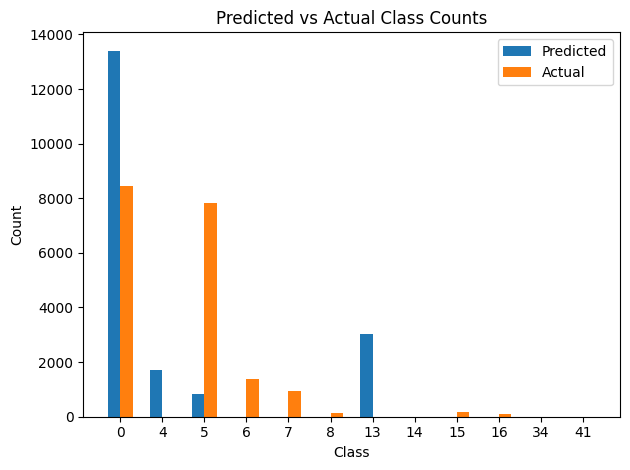

In [118]:
import matplotlib.pyplot as plt
# 막대그래프 그리기
x = np.arange(len(filtered_labels))  # x축 좌표
width = 0.3  # 막대 너비

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, filtered_predicted_count, width, label='Predicted')
rects2 = ax.bar(x + width/2, filtered_actual_count, width, label='Actual')

# 그래프에 레이블 추가
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Predicted vs Actual Class Counts')
ax.set_xticks(x)
ax.set_xticklabels(filtered_labels)
ax.legend()

fig.tight_layout()

plt.show()

In [ ]:
accuracy_node = calc_acc_plot(predictions_node, labels_node)


## test data 하나씩1

In [120]:
def calc_acc_plot(pred, label):
            # edge prediction   
        _, predicted_classes = torch.max(pred, dim=1) # dim=1은 노드별로 최댓값을 찾음



        correct_predictions = (predicted_classes == label)

        accuracy = correct_predictions.float().mean().item()

        plot_class_frequencies(predicted_classes, label)


        return accuracy


def plot_class_frequencies(predicted_classes, label):
    # Convert tensors to numpy arrays for plotting
    predicted_classes = predicted_classes.numpy()
    label = label.numpy()

    # Get unique classes and their counts
    classes = np.unique(np.concatenate((predicted_classes, label)))
    pred_counts = [np.sum(predicted_classes == cls) for cls in classes]
    label_counts = [np.sum(label == cls) for cls in classes]

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Set the bar width
    bar_width = 0.35
    # Set the index for groups
    index = np.arange(len(classes))

    # Create bars for predicted and actual labels
    ax.bar(index, pred_counts, bar_width, label='Predicted')
    ax.bar(index + bar_width, label_counts, bar_width, label='Actual')

    ax.set_xlabel('Classes')
    ax.set_ylabel('Frequency')
    ax.set_title('Predicted vs Actual Class Frequencies')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(classes)
    ax.legend()

    # Save the plot to a file
    plt.tight_layout()
    # plt.savefig('class_frequencies.png')  # Saves the plot as a PNG file
    plt.show()


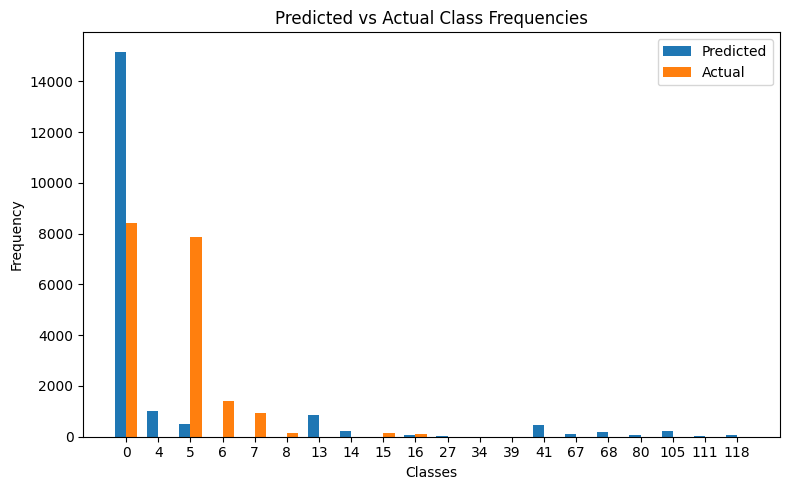

Test loss: 4.5575930232093445 RMSE: 2.3203187 edge acc: 0 node acc: 0.36134499311447144


In [121]:
num_atom_type = 119
num_edge_type = 4

predictions_node = []
labels_node = []
predictions_edge = []
labels_edge = []


predictions = []
labels = []

with torch.no_grad():
    model.eval()
    linear_pred_atoms.eval()
    linear_pred_bonds.eval()

    test_loss = 0.0
    num_data = 0
    for bn, data in enumerate(test_loader):
        data = data.to(device)

        data_recon = data.clone()

        if args.mask_edge:
            loss, pred_node,mask_node_label0, pred_edge,mask_edge_label  = _step_test([model, linear_pred_atoms, linear_pred_bonds], data, bn)
            labels_node.append(mask_node_label0)
            predictions_node.append(pred_node)

            labels_edge.append(mask_edge_label)
            predictions_edge.append(pred_edge)

        else:
            loss, pred_node, mask_node_label0, _, _ = _step_test([model, linear_pred_atoms, linear_pred_bonds], data, bn)

            labels_node.append(mask_node_label0)
            predictions_node.append(pred_node)

        test_loss += loss.item() * data.y.size(0)
        num_data += data.y.size(0)

    test_loss /= num_data

if args.mask_edge:

    labels_edge = torch.cat(labels_edge, dim=0).cpu()
    predictions_edge = torch.cat(predictions_edge, dim=0).cpu().detach()

    labels_node = torch.cat(labels_node, dim=0).cpu()
    predictions_node = torch.cat(predictions_node, dim=0).cpu().detach()


    accuracy_edge = calc_acc(predictions_edge, labels_edge)

    accuracy_node = calc_acc_plot(predictions_node, labels_node)

    acc_node = accuracy_node
    acc_edge = accuracy_edge

else:

    labels_node = torch.cat(labels_node, dim=0).cpu()
    predictions_node = torch.cat(predictions_node, dim=0).cpu().detach()

    accuracy_node = calc_acc_plot(predictions_node, labels_node)
    accuracy_edge = 0
   

    acc_node = accuracy_node
    acc_edge = accuracy_edge


_, pred = model(data)  # [N,C]  

if normalizer: 
    pred = normalizer.denorm(pred)

if config['dataset']['task'] == 'classification':
    
    labels.append(data.y.view(pred.shape))
    predictions.append(pred)

else:
    if device == 'cpu':
        predictions.extend(pred.detach().numpy())
        labels.extend(data.y.flatten().numpy())
    else:
        predictions.extend(pred.cpu().detach().numpy())
        labels.extend(data.y.cpu().flatten().numpy())

if config['dataset']['task'] == 'regression':
    predictions = np.array(predictions)
    labels = np.array(labels)
    if config['task_name'] in ['qm7', 'qm8', 'qm9']:
        mae = mean_absolute_error(labels, predictions)
        mae = mae
        print('Test loss:', test_loss, 'MAE:', mae,  'edge acc:', accuracy_edge, 'node acc:', accuracy_node)
        

    else:
        rmse = root_mean_squared_error(labels, predictions, )
        rmse = rmse

        print('Test loss:', test_loss, 'RMSE:', rmse, 'edge acc:', accuracy_edge, 'node acc:', accuracy_node)


elif config['dataset']['task'] == 'classification':
    
    labels = torch.cat(labels, dim=0).cpu().numpy()
    predictions = torch.cat(predictions, dim=0).cpu().detach().numpy()

    is_valid = labels**2 > 0
    roc_auc = get_roc_auc_score(labels, predictions, is_valid)
    roc_auc = roc_auc

    print('Test loss:', test_loss, 'ROC AUC:', roc_auc, 'edge acc:', accuracy_edge, 'node acc:', accuracy_node)


# model.train()
# linear_pred_atoms.train()
# linear_pred_bonds.train()


In [170]:
target_values

array([-1])

In [157]:
it = iter(test_loader)
test = next(it)

In [171]:
test.y[0]

tensor([1])

In [ ]:
import rdkit
from rdkit import Chem
from rdkit.Chem.rdchem import HybridizationType
from rdkit.Chem.rdchem import BondType as BT
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles
from rdkit import RDLogger

ATOM_LIST = list(range(1,119))
CHIRALITY_LIST = [
    Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
    Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
    Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
    Chem.rdchem.ChiralType.CHI_OTHER
]
BOND_LIST = [BT.SINGLE, BT.DOUBLE, BT.TRIPLE, BT.AROMATIC]
BONDDIR_LIST = [
    Chem.rdchem.BondDir.NONE,
    Chem.rdchem.BondDir.ENDUPRIGHT,
    Chem.rdchem.BondDir.ENDDOWNRIGHT
]

In [91]:
mol = Chem.MolFromSmiles(smiles)

In [92]:
config['dataset']['task']

'classification'

In [93]:
labels = 1

In [94]:

from tqdm import tqdm as core_tqdm
from typing import List, Set, Tuple, Union, Dict
from collections import defaultdict

def onek_encoding_unk(value : int, choices: List[int]) -> List[int]:
    """
        Creates a one-hot encoding.

    :param value: The value for which the encoding should be one.
    :param choices: A list of possible values.
    :return: A one-hot encoding of the value in a list of length len(choices) + 1.
    If value is not in the list of choices, then the final element in the encoding is 1.

    """
    encoding = [0] * len(choices)
    if value in choices:
        encoding[choices.index(value)] = 1
    else:
        encoding[-1] = 1
    return encoding

# rich_feature로 사용할 feature
ATOM_FEATURES = {
    'atomic_num' : list(range(1, 119)),
    'degree' : [0,1,2,3,4,5],
    'formal_charge' : [0, -1, -2, 1, 2],
    'chiral_tag' : [0,1,2,3],
    'num_Hs' : [0,1,2,3,4],
    'hybridization': [

        Chem.rdchem.HybridizationType.SP,
        Chem.rdchem.HybridizationType.SP2,
        Chem.rdchem.HybridizationType.SP3,
        Chem.rdchem.HybridizationType.SP3D,
        Chem.rdchem.HybridizationType.SP3D2
    ],
}

from descriptastorus.descriptors import rdDescriptors, rdNormalizedDescriptors


In [95]:
config['dataset']['task']

'classification'

In [96]:
mol = Chem.AddHs(mol)

N = mol.GetNumAtoms()
M = mol.GetNumBonds()

type_idx = []
chirality_idx = []
atomic_number = []
formal_charge = []
total_numHs = []
hybridzation = []
aromatic = []
mass = []

implicitValence_list = []
hydrogen_acceptor_match_list = []
hydrogen_donor_match_list = []
acidic_match_list = []
basic_match_list = []
ring_info_list = []

degree = []


hydrogen_donor = Chem.MolFromSmarts("[$([N;!H0;v3,v4&+1]),$([O,S;H1;+0]),n&H1&+0]")
hydrogen_acceptor = Chem.MolFromSmarts(
    "[$([O,S;H1;v2;!$(*-*=[O,N,P,S])]),$([O,S;H0;v2]),$([O,S;-]),$([N;v3;!$(N-*=[O,N,P,S])]),"
    "n&H0&+0,$([o,s;+0;!$([o,s]:n);!$([o,s]:c:n)])]")
acidic = Chem.MolFromSmarts("[$([C,S](=[O,S,P])-[O;H1,-1])]")
basic = Chem.MolFromSmarts(
    "[#7;+,$([N;H2&+0][$([C,a]);!$([C,a](=O))]),$([N;H1&+0]([$([C,a]);!$([C,a](=O))])[$([C,a]);"
"!$([C,a](=O))]),$([N;H0&+0]([C;!$(C(=O))])([C;!$(C(=O))])[C;!$(C(=O))])]")


for atom in mol.GetAtoms():
    type_idx.append(ATOM_LIST.index(atom.GetAtomicNum()))
    chirality_idx.append(CHIRALITY_LIST.index(atom.GetChiralTag()))
    degree.append( onek_encoding_unk(atom.GetTotalDegree(), ATOM_FEATURES['degree']) )
    formal_charge.append( onek_encoding_unk(atom.GetFormalCharge(), ATOM_FEATURES['formal_charge']) )
    total_numHs.append( onek_encoding_unk(int(atom.GetTotalNumHs()), ATOM_FEATURES['num_Hs']) )
    hybridzation.append( onek_encoding_unk(int(atom.GetHybridization()), ATOM_FEATURES['hybridization']) )
    aromatic.append([1 if atom.GetIsAromatic() else 0])
    mass.append([atom.GetMass() * 0.01])

    atom_idx = atom.GetIdx()

    hydrogen_donor_match = sum(mol.GetSubstructMatches(hydrogen_donor), ())
    hydrogen_acceptor_match = sum(mol.GetSubstructMatches(hydrogen_acceptor), ())
    acidic_match = sum(mol.GetSubstructMatches(acidic), ())
    basic_match = sum(mol.GetSubstructMatches(basic), ())

    implicitValence_list.append(onek_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6]))
    hydrogen_acceptor_match_list.append([atom_idx in hydrogen_acceptor_match])
    hydrogen_donor_match_list.append([atom_idx in hydrogen_donor_match])
    acidic_match_list.append([atom_idx in acidic_match])
    basic_match_list.append([atom_idx in basic_match])

    ring_info = mol.GetRingInfo()
    ring_info_list.append(                [ring_info.IsAtomInRingOfSize(atom_idx, 3),
            ring_info.IsAtomInRingOfSize(atom_idx, 4),
            ring_info.IsAtomInRingOfSize(atom_idx, 5),
            ring_info.IsAtomInRingOfSize(atom_idx, 6),
            ring_info.IsAtomInRingOfSize(atom_idx, 7),
            ring_info.IsAtomInRingOfSize(atom_idx, 8)])
                                   
                   
x1 = torch.tensor(type_idx, dtype=torch.long).view(-1, 1)
x2 = torch.tensor(chirality_idx, dtype=torch.long).view(-1, 1)
x3 = torch.tensor(degree, dtype=torch.long)
x4 = torch.tensor(formal_charge, dtype=torch.long)
x5 = torch.tensor(total_numHs, dtype=torch.long)
x6 = torch.tensor(hybridzation, dtype=torch.long)
x7 = torch.tensor(aromatic, dtype=torch.long)
x8 = torch.tensor(mass, dtype=torch.float)

x9 = torch.tensor(implicitValence_list, dtype=torch.long)
x10 = torch.tensor(hydrogen_acceptor_match_list, dtype=torch.long)
x11 = torch.tensor(hydrogen_donor_match_list, dtype=torch.long)
x12 = torch.tensor(acidic_match_list, dtype=torch.long)
x13 = torch.tensor(basic_match_list, dtype=torch.long)
x14 = torch.tensor(ring_info_list, dtype=torch.long)


x = torch.cat([x1, x2, x3, x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14], dim=1)

row, col, edge_feat = [], [], []
for bond in mol.GetBonds():
    start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
    row += [start, end]
    col += [end, start]
    bt = bond.GetBondType()
    feat1 = [
        BOND_LIST.index(bond.GetBondType()),
        BONDDIR_LIST.index(bond.GetBondDir()),
        bond.GetIsConjugated() if bt is not None else 0,
        bond.IsInRing() if bt is not None else 0,
        *onek_encoding_unk(int(bond.GetStereo()), list(range(6)))
    ]
    edge_feat.append(feat1)

    # 반대 방향의 엣지(또는 같은 특성을 반복) 특성 계산
    # 여기서는 예시로 feat1을 그대로 사용합니다. 필요에 따라 다른 계산을 할 수 있습니다.
    feat2 = feat1  # 또는 반대 방향에 대한 다른 계산 결과
    edge_feat.append(feat2)
        

edge_index = torch.tensor([row, col], dtype=torch.long)
edge_attr = torch.tensor(np.array(edge_feat), dtype=torch.long)
if config['dataset']['task'] == 'classification':
    y = torch.tensor(labels, dtype=torch.long).view(1,-1)
elif config['dataset']['task'] == 'regression':
    y = torch.tensor(labels * conversion, dtype=torch.float).view(1,-1)


normalized_2d_generator = rdNormalizedDescriptors.RDKit2DNormalized()
x_add = normalized_2d_generator.process(smiles)
if x_add is None:
    # x_add가 None인 경우, 처리 방식 결정
    # 예: 빈 특성 리스트 또는 기본값 설정
    print(f"Warning: No features generated for SMILES: {smiles}")
    x_add = [] # 예시 기본값
else:
    # x_add를 텐서로 변환

    x_add = torch.tensor(np.array(x_add[1:]), dtype=torch.long).view(1, -1)


data = Data(x=x, y=y, edge_index=edge_index, edge_attr=edge_attr, x_add = x_add)

In [97]:
data = data.to(device)

In [98]:
data.batch = torch.zeros(x.size(0), dtype=torch.long).to(device)

In [99]:
h_node, pred, node = model(data,3)

In [100]:
N = mol.GetNumAtoms()

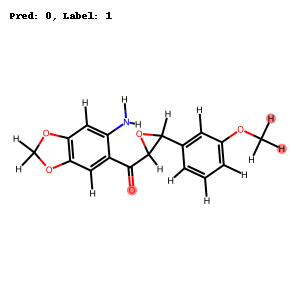

In [101]:
from rdkit.Chem import Draw

img = Draw.MolToImage(mol, highlightAtoms=node.tolist())
from PIL import Image, ImageDraw


pred_max_index = pred.detach().cpu().numpy().argmax()
# 이미지에 텍스트 추가 (예측 결과와 실제 레이블)
draw = ImageDraw.Draw(img)
text = f"Pred: {pred_max_index}, Label: {data.y.item()}"
draw.text((10, 10), text, fill="black")

# save_path = os.path.join(save_dir, f"molecule_3mr.png")
# img.save(save_path)  # 파일 이름을 분자의 인덱스에 따라 지정
display(img)

## 파이썬 파일 실행

In [1]:
datasets = [ 'FreeSolv', 'ESOL', 'Lipo', 'qm7', "bace",  "bbbp",  'tox21',  'sider']
mask_rates = [0.2,0.9]

for mask_rate in mask_rates:
    for dataset in datasets:
                if dataset == 'FreeSolv':
                # FreeSolv 데이터셋에 대한 특정 옵션을 적용
                    !python Recon+predict_plot.py \
                    --task_name {dataset} \
                    --seed 781 \
                    --dropout 0.5 \
                    --num_layer 3 \
                    --emb_dim 64 \
                    --feat_dim 64 \
                    --alpha 0.1 \
                    --mask_rate {mask_rate} \
                    --gpu cuda:0
             
                        
                else:
                    !python Recon+predict_plot.py \
                    --task_name {dataset} \
                    --seed 781 \
                    --gpu cuda:0 \
                    --alpha 0.1 \
                    --mask_rate {mask_rate} 

                

Please install apex for mixed precision training from: https://github.com/NVIDIA/apex
{'batch_size': 32, 'epochs': 200, 'eval_every_n_epochs': 1, 'fine_tune_from': 'pretrained_gin', 'log_every_n_steps': 50, 'fp16_precision': False, 'init_lr': 0.0005, 'init_base_lr': 0.0001, 'weight_decay': '1e-6', 'gpu': 'cuda:0', 'task_name': 'freesolv', 'model_type': 'gin', 'model': {'num_layer': 3, 'emb_dim': 64, 'feat_dim': 64, 'drop_ratio': 0.5, 'pool': 'mean'}, 'dataset': {'num_workers': 4, 'valid_size': 0.1, 'test_size': 0.1, 'splitting': 'scaffold', 'seed': 781, 'task': 'regression', 'data_path': 'data/freesolv/freesolv.csv', 'target': ['expt']}}
Running on: cuda:0
641
About to generate scaffolds
Generating scaffold 0/641
About to sort in scaffold sets
pred_head.0.weight True
pred_head.0.bias True
pred_head.2.weight True
pred_head.2.bias True
pred_head.4.weight True
pred_head.4.bias True
0 0 16.531320571899414 0.0 0
Validation loss: 63.384979248046875 node acc: 0.0
Validation loss: 57.533357620

In [ ]:
datasets = [ 'FreeSolv', 'ESOL', 'Lipo', 'qm7', "bace",  "bbbp",  'tox21',  'sider']

for dataset in datasets:
            if dataset == 'FreeSolv':
            # FreeSolv 데이터셋에 대한 특정 옵션을 적용
                !python Recon+predict_plot.py \
                --task_name {dataset} \
                --seed 781 \
                --dropout 0.5 \
                --num_layer 3 \
                --emb_dim 64 \
                --feat_dim 64 \
                --alpha 0.1 \
                --mask_rate 0.9 \
                --gpu cuda:0
         
                    
            else:
                !python Recon+predict_plot.py \
                --task_name {dataset} \
                --seed 781 \
                --gpu cuda:0 \
                --alpha 0.1 \
                --mask_rate 0.9 

                

Please install apex for mixed precision training from: https://github.com/NVIDIA/apex
{'batch_size': 32, 'epochs': 200, 'eval_every_n_epochs': 1, 'fine_tune_from': 'pretrained_gin', 'log_every_n_steps': 50, 'fp16_precision': False, 'init_lr': 0.0005, 'init_base_lr': 0.0001, 'weight_decay': '1e-6', 'gpu': 'cuda:0', 'task_name': 'freesolv', 'model_type': 'gin', 'model': {'num_layer': 3, 'emb_dim': 64, 'feat_dim': 64, 'drop_ratio': 0.5, 'pool': 'mean'}, 'dataset': {'num_workers': 4, 'valid_size': 0.1, 'test_size': 0.1, 'splitting': 'scaffold', 'seed': 781, 'task': 'regression', 'data_path': 'data/freesolv/freesolv.csv', 'target': ['expt']}}
Running on: cuda:0
641
About to generate scaffolds
Generating scaffold 0/641
About to sort in scaffold sets
pred_head.0.weight True
pred_head.0.bias True
pred_head.2.weight True
pred_head.2.bias True
pred_head.4.weight True
pred_head.4.bias True
0 0 16.53340721130371 0.007259528152644634 0
Validation loss: 63.38872146606445 node acc: 0.0
Validation los

In [2]:
datasets = [ 'FreeSolv', 'ESOL', 'Lipo', 'qm7', "bace",  "bbbp",  'tox21',  'sider']

for dataset in datasets:
            if dataset == 'FreeSolv':
            # FreeSolv 데이터셋에 대한 특정 옵션을 적용
                !python Recon+predict_plot.py \
                --task_name {dataset} \
                --seed 781 \
                --dropout 0.5 \
                --num_layer 3 \
                --emb_dim 64 \
                --feat_dim 64 \
                --alpha 0.1 \
                --mask_rate 0.2 \
                --gpu cuda:0
         
                    
            else:
                !python Recon+predict_plot.py \
                --task_name {dataset} \
                --seed 781 \
                --gpu cuda:0 \
                --alpha 0.1 \
                --mask_rate 0.2 

                

Please install apex for mixed precision training from: https://github.com/NVIDIA/apex
{'batch_size': 32, 'epochs': 200, 'eval_every_n_epochs': 1, 'fine_tune_from': 'pretrained_gin', 'log_every_n_steps': 50, 'fp16_precision': False, 'init_lr': 0.0005, 'init_base_lr': 0.0001, 'weight_decay': '1e-6', 'gpu': 'cuda:0', 'task_name': 'freesolv', 'model_type': 'gin', 'model': {'num_layer': 3, 'emb_dim': 64, 'feat_dim': 64, 'drop_ratio': 0.5, 'pool': 'mean'}, 'dataset': {'num_workers': 4, 'valid_size': 0.1, 'test_size': 0.1, 'splitting': 'scaffold', 'seed': 781, 'task': 'regression', 'data_path': 'data/freesolv/freesolv.csv', 'target': ['expt']}}
Running on: cuda:0
641
About to generate scaffolds
Generating scaffold 0/641
About to sort in scaffold sets
pred_head.0.weight True
pred_head.0.bias True
pred_head.2.weight True
pred_head.2.bias True
pred_head.4.weight True
pred_head.4.bias True
0 0 16.531320571899414 0.0 0
Validation loss: 63.38494300842285 node acc: 0.0
Validation loss: 57.5333003997

In [39]:
!python Recon+predict_plot.py \
--task_name lipo \
--seed 789 \
--gpu cuda:0 \
--alpha 0.1 \
--mask_rate 0.2 \
--epochs 1

Please install apex for mixed precision training from: https://github.com/NVIDIA/apex
{'batch_size': 32, 'epochs': 1, 'eval_every_n_epochs': 1, 'fine_tune_from': 'pretrained_gin', 'log_every_n_steps': 50, 'fp16_precision': False, 'init_lr': 0.0005, 'init_base_lr': 0.0001, 'weight_decay': '1e-6', 'gpu': 'cuda:0', 'task_name': 'lipo', 'model_type': 'gin', 'model': {'num_layer': 5, 'emb_dim': 300, 'feat_dim': 300, 'drop_ratio': 0.3, 'pool': 'mean'}, 'dataset': {'num_workers': 4, 'valid_size': 0.1, 'test_size': 0.1, 'splitting': 'scaffold', 'seed': 789, 'task': 'regression', 'data_path': 'data/lipophilicity/Lipophilicity.csv', 'target': ['exp']}}
Running on: cuda:0
4199
About to generate scaffolds
Generating scaffold 0/4199
Generating scaffold 1000/4199
Generating scaffold 2000/4199
Generating scaffold 3000/4199
Generating scaffold 4000/4199
About to sort in scaffold sets
pred_head.0.weight True
pred_head.0.bias True
pred_head.2.weight True
pred_head.2.bias True
pred_head.4.weight True
pre

In [158]:
!python finetune3_tsne.py \
 --task_name bace \
--seed 750 \
--gpu cuda:0 \
--weight_decay 1e-6 \
--mask_rate 0.2

Please install apex for mixed precision training from: https://github.com/NVIDIA/apex
{'batch_size': 32, 'epochs': 200, 'eval_every_n_epochs': 1, 'fine_tune_from': 'pretrained_gin', 'log_every_n_steps': 50, 'fp16_precision': False, 'init_lr': 0.0005, 'init_base_lr': 0.0001, 'weight_decay': '1e-6', 'gpu': 'cuda:0', 'task_name': 'bace', 'model_type': 'gin', 'model': {'num_layer': 5, 'emb_dim': 300, 'feat_dim': 300, 'drop_ratio': 0.3, 'pool': 'mean'}, 'dataset': {'num_workers': 4, 'valid_size': 0.1, 'test_size': 0.1, 'splitting': 'scaffold', 'seed': 750, 'task': 'classification', 'data_path': 'data/bace/bace.csv', 'target': ['Class']}}
Running on: cuda:0
1512
About to generate scaffolds
Generating scaffold 0/1512
Generating scaffold 1000/1512
About to sort in scaffold sets
pred_head.0.weight True
pred_head.0.bias True
pred_head.2.weight True
pred_head.2.bias True
pred_head.4.weight True
pred_head.4.bias True
0 0 0.6962036490440369
Validation loss: 0.831542025338735 ROC AUC: 0.473777462792